In [6]:
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
import sys

drive.mount('/content/gdrive')
base_dir_path = "gdrive/My Drive/UpGrad/Capstone"
sys.path.insert(0, base_dir_path)

Mounted at /content/gdrive


In [ ]:
# ! pip install gensim

In [46]:
# Import packages
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import wordcloud

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import confusion_matrix

import pickle
from sklearn.model_selection import RandomizedSearchCV

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


## **Import Ratings CVS and Explore**

In [9]:
# Create ratings dataframe from csv
ratings_df = pd.read_csv(f"{base_dir_path}/sample30.csv")
ratings_df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess.",Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,NaN,NaN,walker557,Negative


In [10]:
# Check the rows x cols of the dataframe
ratings_df.shape

(30000, 15)

In [11]:
# Check all the columns in the dataframe
ratings_df.columns

Index(['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date',
       'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating',
       'reviews_text', 'reviews_title', 'reviews_userCity',
       'reviews_userProvince', 'reviews_username', 'user_sentiment'],
      dtype='object')

In [12]:
# Check relevant fields
ratings_df[['reviews_username', 'name', 'reviews_rating', 'reviews_text', 'reviews_title']]

,reviews_username,name,reviews_rating,reviews_text,reviews_title
0,joshua,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome
1,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor. This review was collected as part of a promotion.,Good
2,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor.,Good
3,rebecca,K-Y Love Sensuality Pleasure Gel,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess.",Disappointed
4,walker557,K-Y Love Sensuality Pleasure Gel,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation
...,...,...,...,...,...
29995,laurasnchz,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,5,"I got this conditioner with Influenster to try it and im loving it so far, i have oily hair so i use it only in the ends of my hair and feels amazing, so soft and no mess!! This review was collected as part of a promotion.",Softness!!
29996,scarlepadilla,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,5,"I love it , I received this for review purposes from influenster and it leaves my hair feeling fresh and smelling great",I love it
29997,liviasuexo,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,5,First of all I love the smell of this product. After you wash your hair it is so smooth and easy to brush! I did receive this product from influenster for testing purposes but all opinions ARE my own! This review was collected as part of a promotion.,Hair is so smooth after use
29998,ktreed95,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,5,"I received this through Influenster and will never go back to anything else! I normally don't use conditioner because my hair is so oily and fine. This does not make my hair feel heavy, and it doesn't get oily during the day! It really is fantastic and plan on buying it in the future! This review was collected as part of a promotion.",Perfect for my oily hair!


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


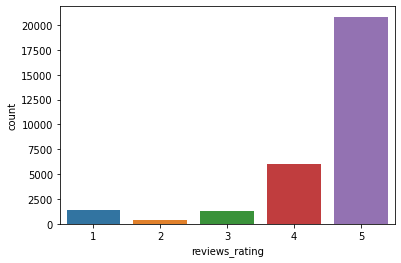

In [14]:
# Check how the ratings are distributed.
sns.countplot(ratings_df.reviews_rating)

### **Observation**

We can see above that most of the ratings given are given for 5. Very few ratings of less than 4.

In [15]:
ratings_df.reviews_rating.value_counts()

5    20831
4    6020 
1    1384 
3    1345 
2    420  
Name: reviews_rating, dtype: int64

In [16]:
# Let's check the unique number of values in each column. Mostly checking for unique products
ratings_df.nunique()

id                      271  
brand                   214  
categories              270  
manufacturer            227  
name                    271  
reviews_date            6857 
reviews_didPurchase     2    
reviews_doRecommend     2    
reviews_rating          5    
reviews_text            27282
reviews_title           18535
reviews_userCity        977  
reviews_userProvince    42   
reviews_username        24914
user_sentiment          2    
dtype: int64

### **Observation**

- There are 271 unique products reviewed in the dataset
- There are 24,914 unique users

## **Data Cleaning**

### **Handle Null Values**

In [17]:
ratings_df.isnull().sum()

id                      0    
brand                   0    
categories              0    
manufacturer            141  
name                    0    
reviews_date            46   
reviews_didPurchase     14068
reviews_doRecommend     2570 
reviews_rating          0    
reviews_text            0    
reviews_title           190  
reviews_userCity        28071
reviews_userProvince    29830
reviews_username        63   
user_sentiment          1    
dtype: int64

**Observation**
- 190 ratings do not have a title.
- 63 ratings do not have a username.
- 1 rating does not have a sentiment assigned.


In [18]:
ratings_df[ratings_df.reviews_title.isnull()].head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
1239,AV1YneDPglJLPUi8IJyQ,Finish,"Household Essentials,Cleaning Supplies,Dish Detergents,Ways To Shop,Household Essentials Subscriptions,Kitchen,Dishwasher Detergent,Natural Cleaning,Glass Cleaners,Dish Detergent",Reckitt Benckiser,"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",2017-11-16T08:12:30.000Z,NaN,True,5,Great quality and a great price,NaN,NaN,NaN,queen 79,Positive
1441,AVpe_dxlilAPnD_xSiHI,The Seaweed Bath Co.,"Personal Care,Hair Care,Conditioner,Beauty,Shampoo & Conditioner,Salon Hair Care,Conditioners",The Seaweed Bath,"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",2013-11-07T00:00:00Z,NaN,NaN,3,Wanted to love this but it's a bit too heavy for me. I have mild psoriasis and this seemed to make it itch more?? think it's the argan oil - must be allergic.,NaN,NaN,NaN,julie,Positive
1442,AVpe_dxlilAPnD_xSiHI,The Seaweed Bath Co.,"Personal Care,Hair Care,Conditioner,Beauty,Shampoo & Conditioner,Salon Hair Care,Conditioners",The Seaweed Bath,"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",2015-02-09T00:00:00Z,NaN,NaN,3,I have thick coarse hair and for me this just worked ok. It did not smooth as much as other products I have tried. It has a scent that is acceptable.,NaN,NaN,NaN,lisa,Negative
1443,AVpe_dxlilAPnD_xSiHI,The Seaweed Bath Co.,"Personal Care,Hair Care,Conditioner,Beauty,Shampoo & Conditioner,Salon Hair Care,Conditioners",The Seaweed Bath,"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",2013-11-07T00:00:00Z,NaN,NaN,3,Wanted to love this but it's a bit too heavy for me. I have mild psoriasis and this seemed to make it itch moreI think it's the argan oil - must be allergic.,NaN,NaN,NaN,julie,Positive
1444,AVpe_dxlilAPnD_xSiHI,The Seaweed Bath Co.,"Personal Care,Hair Care,Conditioner,Beauty,Shampoo & Conditioner,Salon Hair Care,Conditioners",The Seaweed Bath,"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",2017-11-27T18:18:38.000Z,NaN,True,4,"I actually really enjoy this conditioner. Have tried a whole bunch, both expensive and cheap. I have thick, curly and dry hair so I'm pretty particular about what I use. Smell is nice! I used it with the Moisturizing unscented shampoo and feel like the combo of the two is keeping my hair very healthy. I've also noticed less frizz as well. I've only used it a couple times but I only wash my hair once ever 4-5 days or so. Scalp isn't greasy and hair isn't dried out. Curls aren't too frizzy either!",NaN,NaN,NaN,aland,Positive


In [19]:
# replace missing reviews_title with emtpy string.
ratings_df["reviews_title"] = ratings_df.reviews_title.fillna('')
ratings_df.isnull().sum()

id                      0    
brand                   0    
categories              0    
manufacturer            141  
name                    0    
reviews_date            46   
reviews_didPurchase     14068
reviews_doRecommend     2570 
reviews_rating          0    
reviews_text            0    
reviews_title           0    
reviews_userCity        28071
reviews_userProvince    29830
reviews_username        63   
user_sentiment          1    
dtype: int64

In [20]:
# check records where user sentiment is null
ratings_df[ratings_df["user_sentiment"].isnull()]

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
28354,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Ways To Shop Entertainment,Movies & Tv On Blu-Ray,Movies & TV,Disney,Blu-ray,Children & Family,Movies & Music,Movies & TV Shows,Electronics, Tech Toys, Movies, Music,Blu-Rays,See ALL Blu-Ray,Frys",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),2014-11-07T00:00:00.000Z,NaN,True,5,my kids absolutely loved this film so much that we watched it twice. Having a digital copy means that every time we get in the car we get to watch it wherever we go. we even got to use our $5 reward coupon towards the purchase of this movie so we got an additional $5 off + we got to add the points towards our next rewards coupon we love the savings we get at Best Buy,a super hit with my children. they loved it!!??,NaN,mamad,7.87E+11,NaN


In [21]:
# since the rating is 5, we will impute the missing sentiment value with Positive
ratings_df["user_sentiment"] = ratings_df.user_sentiment.fillna('Positive')
ratings_df.isnull().sum()

id                      0    
brand                   0    
categories              0    
manufacturer            141  
name                    0    
reviews_date            46   
reviews_didPurchase     14068
reviews_doRecommend     2570 
reviews_rating          0    
reviews_text            0    
reviews_title           0    
reviews_userCity        28071
reviews_userProvince    29830
reviews_username        63   
user_sentiment          0    
dtype: int64

#### **Create reviews_text_w_title column by concatination reviews title and text**

In [22]:
# Create a new columns which includes both reviews title and text.
ratings_df['reviews_text_w_title'] = ratings_df['reviews_title'] + '. ' + ratings_df['reviews_text']
ratings_df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,reviews_text_w_title
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,Positive,Just Awesome. i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive,Good. Good flavor. This review was collected as part of a promotion.
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive,Good. Good flavor.
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess.",Disappointed,NaN,NaN,rebecca,Negative,"Disappointed. I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess."
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,NaN,NaN,walker557,Negative,Irritation. My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.


In [23]:
# Drop reviews_title and reviews_text, after deriving reviews_text_w_title
ratings_df.drop(columns=['reviews_text', 'reviews_title'], inplace=True)
ratings_df.columns

Index(['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date',
       'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating',
       'reviews_userCity', 'reviews_userProvince', 'reviews_username',
       'user_sentiment', 'reviews_text_w_title'],
      dtype='object')

In [24]:
# Rename reviews_text_w_title with reviews_text.
ratings_df.rename(columns={"reviews_text_w_title": "reviews_text"}, inplace=True)
ratings_df.columns

Index(['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date',
       'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating',
       'reviews_userCity', 'reviews_userProvince', 'reviews_username',
       'user_sentiment', 'reviews_text'],
      dtype='object')

#### **Make user_sentiment column numeric. Convert Positive = 1 and Negative = 0**

In [25]:
ratings_df.user_sentiment.value_counts()

Positive    26633
Negative    3367 
Name: user_sentiment, dtype: int64

In [26]:
ratings_df['user_sentiment'] = ratings_df.user_sentiment.map({
    'Positive': 1,
    'Negative': 0
})
ratings_df.user_sentiment.value_counts()

1    26633
0    3367 
Name: user_sentiment, dtype: int64

### **Drop duplicates (name, reviews_username) pairs and keep the last one**

In [27]:
# List duplicate entries
ratings_df[ratings_df.duplicated(subset=['name','reviews_username'])].head(5)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,reviews_text
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,NaN,NaN,dorothy w,1,Good. Good flavor.
12,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-04-08T00:00:00.000Z,False,False,1,NaN,NaN,jds1992,0,"waste of money. Bought this to enhance our time a bit, did abslutely nothing very disappointed especially because its almost 20!"
44,AV1h6Gu0glJLPUi8IjA_,Johnson's,"Personal Care,Baby Care,Baby Bubble Bath,Baby,Bath & Potty,Toiletries,Bubble Bath,Baby Bath,Bath & Body,Body Wash & Cleansers",Johnson's,"Johnson's Baby Bubble Bath and Wash, 15oz",2017-05-09T00:00:00.000Z,False,True,4,NaN,NaN,solo,1,"2 in 1!!!. Well, Johnson's need I say more I know, right. Ok, but I will. I have used Johnson's since I was a baby, yes it's been a long time. But let's get to the Chase, it's 2 in 1. Come on, who doesn't like 2 in 1 It's hard enough to get the little loves clean, so any help is always a blessing... So, Johnson's Bubble Bath and wash is a must have in this house!!!"
79,AV1l8zRZvKc47QAVhnAv,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face Moisturizers,Facial Moisturizers,Moisturizers,Creams & Moisturizers",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2016-04-30T00:00:00.000Z,False,True,3,NaN,NaN,mylifeinheels,1,"Why No fragrance-free Formula. Today is my first time using this product. Felt great going on immediately, felt moisturized without being too greasy. Although it smells great I would have loved to have this formula in a fragrance-free option, my skin tends to be a little sensitive to fragrances, but I will give a final review in a couple of weeks"
90,AV1l8zRZvKc47QAVhnAv,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face Moisturizers,Facial Moisturizers,Moisturizers,Creams & Moisturizers",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2016-04-30T03:08:38.000Z,NaN,True,3,Brooklyn,NaN,mylifeinheels,1,"Why No Fragrance-free Formula. Today is my first time using this product. Felt great going on immediately, felt moisturized without being too greasy. Although it smells great I would have loved to have this formula in a fragrance-free option, my skin tends to be a little sensitive to fragrances, but I will give a final review in a couple of weeks"


In [28]:
# Investigate one of the duplicates
ratings_df[
  (ratings_df.name == 'The Resident Evil Collection 5 Discs (blu-Ray)') & 
  (ratings_df.reviews_username == 'markm')
]

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,reviews_text
5250,AVpf0eb2LJeJML43EVSt,Sony Pictures,"Movies, Music & Books,Ways To Shop Entertainment,Movie & Tv Box Sets,Movies,Horror,Movies & TV Shows,All Horror,Movies & Tv On Blu-Ray,Movies & TV,Blu-ray,Action & Adventure,Movies & Music,Holiday Shop",SONY CORP,The Resident Evil Collection 5 Discs (blu-Ray),2017-04-16T00:00:00.000Z,NaN,True,5,NaN,NaN,markm,0,"Great deal, plus bonus!. Bought all five of the first resident evil movies for $15!! And it came with a free ticket to see number seven!"
5358,AVpf0eb2LJeJML43EVSt,Sony Pictures,"Movies, Music & Books,Ways To Shop Entertainment,Movie & Tv Box Sets,Movies,Horror,Movies & TV Shows,All Horror,Movies & Tv On Blu-Ray,Movies & TV,Blu-ray,Action & Adventure,Movies & Music,Holiday Shop",SONY CORP,The Resident Evil Collection 5 Discs (blu-Ray),2017-08-17T00:00:00.000Z,NaN,True,5,NaN,NaN,markm,0,"Best blu ray deal ever!. Al five of the first resident evil movies for less than $20! Does not include the last movie, but a great deal overall"


In [29]:
ratings_df.shape

(30000, 14)

In [30]:
# Sort ratings_df by reviews_date column in descending order.
ratings_df = ratings_df.sort_values(by="reviews_date", ascending=False, inplace=False)
ratings_df.head(5)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,reviews_text
3471,AVpe625_ilAPnD_xQ4SP,Nearly Natural,"Home,Home Decor,Home Accents,Artificial Flowers & Plants,Silk Flowers,Decor,Artificial Plants and Flowers,Artificial Flowers,Indoor Plants,Floral Arrangements,Decorative Accessories,Silk Plants",Nearly Natural,Sunflower Swag With Metal Frame - Nearly Natural,2018-01-10T19:56:37.000Z,NaN,NaN,2,NaN,NaN,bostonshopper,0,"Sunflower Swag. I was disappointed when I received this swag I ordered online and will definitely be returning it. First, the color of the sunflowers is more like a red/orange than yellow. Second, the petals on the sunflowers themselves were all bent. I thought they could easily be bent back in shape, but that isn't the case. I could iron them down, but I won't waste my time. For the price, it's not worth the purchase in my opinion. Sorry, this swag missed the mark for me."
26763,AVpfPx6V1cnluZ0-hA5y,Ben & Jerry's,"Food,Packaged Foods,Dairy & Dairy Substitutes,Desserts,Ice Cream & Frozen Yogurt,Food & Beverage,Frozen Foods,Ice Cream,Ice Cream & Novelties,#18430 in,#1322 in,#306 in",Unilever,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint",2018-01-06T23:44:55.000Z,NaN,True,5,NaN,NaN,coffee dreams,1,"Really, No Words Can Describe The Awesomeness. Best coffee ice cream in the world, hands down!! Never tasted better."
1228,AV1YneDPglJLPUi8IJyQ,Finish,"Household Essentials,Cleaning Supplies,Dish Detergents,Ways To Shop,Household Essentials Subscriptions,Kitchen,Dishwasher Detergent,Natural Cleaning,Glass Cleaners,Dish Detergent",Reckitt Benckiser,"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",2018-01-06T14:17:53.000Z,NaN,NaN,4,NaN,NaN,emmy1977,1,Better Than Cheaper Finish. The cheaper Finish was leaving white residue on our dishes. This one is better and our dishes don't have as much white residue now.
16773,AVpf99c6LJeJML43Gu3K,Warner Bros.,"Movies, Music & Books,Movies,Romance,Drama,Movies & TV,Urban Dramas,Movies & Music,Movies & TV Shows,Classics,Classic Dramas",TIME WARNER,Romantic Drama: Greatest Classic Films Collection 2 Discs,2017-12-26T21:06:40.000Z,NaN,True,5,NaN,NaN,msd,1,"Great. Great deal on four movies for the price of one, fast shipping and my mom loved them!"
18549,AVpfJcHuLJeJML433ZrY,Lionsgate Home Entertainment,"Movies, Music & Books,Movies,Sci-Fi & Fantasy,Romance,Movies & TV,Blu-ray,Documentary,Drama,Movies & Music,Movies & TV Shows",Lions Gate,Equals (blu-Ray),2017-12-26T20:18:47.000Z,NaN,True,5,NaN,NaN,cn,0,. My daughter adored the movie!


In [31]:
after_drop_df = ratings_df.drop_duplicates(subset=['name','reviews_username'], keep="first")
after_drop_df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,reviews_text
3471,AVpe625_ilAPnD_xQ4SP,Nearly Natural,"Home,Home Decor,Home Accents,Artificial Flowers & Plants,Silk Flowers,Decor,Artificial Plants and Flowers,Artificial Flowers,Indoor Plants,Floral Arrangements,Decorative Accessories,Silk Plants",Nearly Natural,Sunflower Swag With Metal Frame - Nearly Natural,2018-01-10T19:56:37.000Z,NaN,NaN,2,NaN,NaN,bostonshopper,0,"Sunflower Swag. I was disappointed when I received this swag I ordered online and will definitely be returning it. First, the color of the sunflowers is more like a red/orange than yellow. Second, the petals on the sunflowers themselves were all bent. I thought they could easily be bent back in shape, but that isn't the case. I could iron them down, but I won't waste my time. For the price, it's not worth the purchase in my opinion. Sorry, this swag missed the mark for me."
26763,AVpfPx6V1cnluZ0-hA5y,Ben & Jerry's,"Food,Packaged Foods,Dairy & Dairy Substitutes,Desserts,Ice Cream & Frozen Yogurt,Food & Beverage,Frozen Foods,Ice Cream,Ice Cream & Novelties,#18430 in,#1322 in,#306 in",Unilever,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint",2018-01-06T23:44:55.000Z,NaN,True,5,NaN,NaN,coffee dreams,1,"Really, No Words Can Describe The Awesomeness. Best coffee ice cream in the world, hands down!! Never tasted better."
1228,AV1YneDPglJLPUi8IJyQ,Finish,"Household Essentials,Cleaning Supplies,Dish Detergents,Ways To Shop,Household Essentials Subscriptions,Kitchen,Dishwasher Detergent,Natural Cleaning,Glass Cleaners,Dish Detergent",Reckitt Benckiser,"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",2018-01-06T14:17:53.000Z,NaN,NaN,4,NaN,NaN,emmy1977,1,Better Than Cheaper Finish. The cheaper Finish was leaving white residue on our dishes. This one is better and our dishes don't have as much white residue now.
16773,AVpf99c6LJeJML43Gu3K,Warner Bros.,"Movies, Music & Books,Movies,Romance,Drama,Movies & TV,Urban Dramas,Movies & Music,Movies & TV Shows,Classics,Classic Dramas",TIME WARNER,Romantic Drama: Greatest Classic Films Collection 2 Discs,2017-12-26T21:06:40.000Z,NaN,True,5,NaN,NaN,msd,1,"Great. Great deal on four movies for the price of one, fast shipping and my mom loved them!"
18549,AVpfJcHuLJeJML433ZrY,Lionsgate Home Entertainment,"Movies, Music & Books,Movies,Sci-Fi & Fantasy,Romance,Movies & TV,Blu-ray,Documentary,Drama,Movies & Music,Movies & TV Shows",Lions Gate,Equals (blu-Ray),2017-12-26T20:18:47.000Z,NaN,True,5,NaN,NaN,cn,0,. My daughter adored the movie!


In [32]:
print(ratings_df.shape)
print(after_drop_df.shape)

(30000, 14)
(27605, 14)


In [33]:
# verify duplicate is dropped
after_drop_df[
  (after_drop_df.name == 'The Resident Evil Collection 5 Discs (blu-Ray)') & 
  (after_drop_df.reviews_username == 'markm')
]

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,reviews_text
5358,AVpf0eb2LJeJML43EVSt,Sony Pictures,"Movies, Music & Books,Ways To Shop Entertainment,Movie & Tv Box Sets,Movies,Horror,Movies & TV Shows,All Horror,Movies & Tv On Blu-Ray,Movies & TV,Blu-ray,Action & Adventure,Movies & Music,Holiday Shop",SONY CORP,The Resident Evil Collection 5 Discs (blu-Ray),2017-08-17T00:00:00.000Z,NaN,True,5,NaN,NaN,markm,0,"Best blu ray deal ever!. Al five of the first resident evil movies for less than $20! Does not include the last movie, but a great deal overall"


In [34]:
# After verification, apply the same drop duplicate methods on ratings_df
ratings_df.drop_duplicates(subset=['name','reviews_username'], keep="first", inplace=True)
ratings_df.shape

(27605, 14)

In [39]:
# lets check null values again and verify that we have reviews_text and name for all entries
ratings_df[['name','reviews_text']].isnull().sum()

name            0
reviews_text    0
dtype: int64

## **EDA**

1    24552
0    3053 
Name: user_sentiment, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


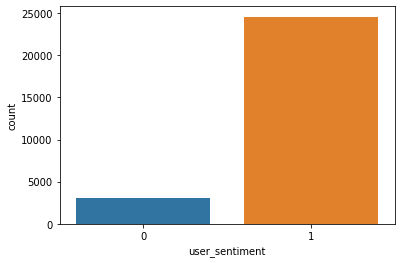

In [43]:
print(ratings_df.user_sentiment.value_counts())
sns.countplot(ratings_df.user_sentiment)

In [45]:
positives = 24552
negatives = 3053
positive_perc = positives * 100 / (positives + negatives)
print(f"{round(positive_perc, 2)}% of reviews are positive")

88.94% of reviews are positive


In [47]:
def show_wordcloud(df, title, text_col_name):
    text = ' '.join(df[text_col_name].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords, background_color="#ffa78c",
                                        width = 3000, height = 2000).generate(text)
    plt.figure(figsize=(15,15), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

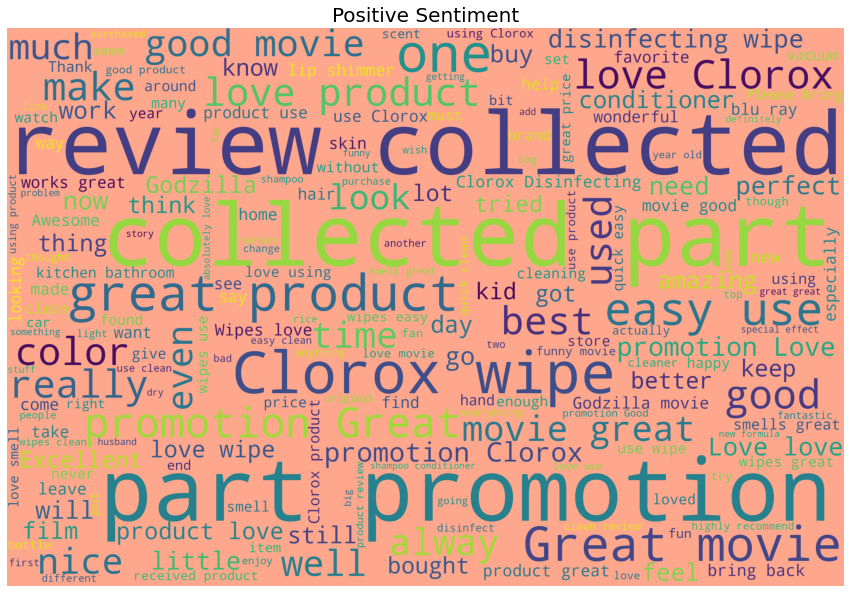

CPU times: user 26.5 s, sys: 429 ms, total: 27 s
Wall time: 26.9 s


In [51]:
%%time
show_wordcloud(ratings_df[ratings_df.user_sentiment == 1], 'Positive Sentiment', 'reviews_text')

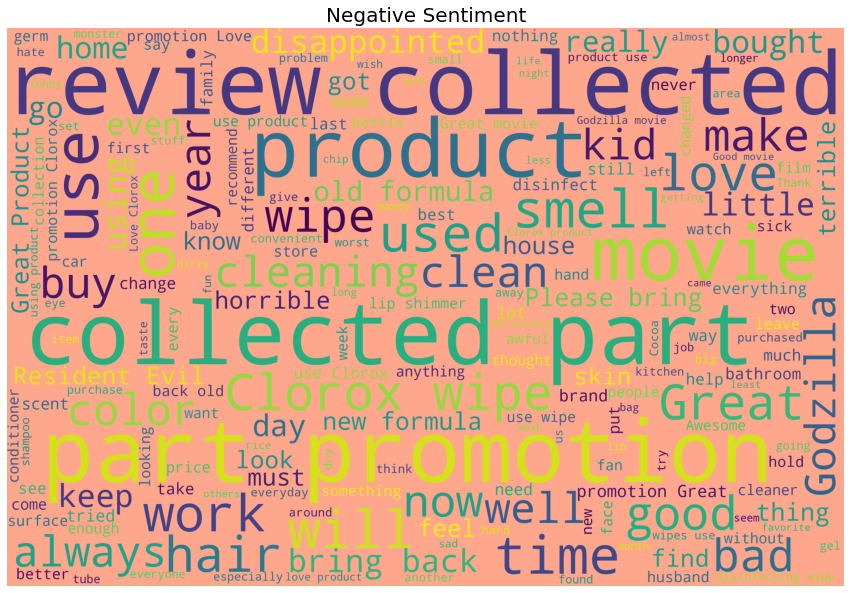

CPU times: user 23 s, sys: 300 ms, total: 23.3 s
Wall time: 23.2 s


In [50]:
%%time
show_wordcloud(ratings_df[ratings_df.user_sentiment == 0], 'Negative Sentiment', 'reviews_text')

In [52]:
# Let's create a reviews_text_len columns, which will store the length of the review in it.
ratings_df['reviews_text_len'] = ratings_df['reviews_text'].apply(len)
ratings_df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,reviews_text,reviews_text_len
3471,AVpe625_ilAPnD_xQ4SP,Nearly Natural,"Home,Home Decor,Home Accents,Artificial Flowers & Plants,Silk Flowers,Decor,Artificial Plants and Flowers,Artificial Flowers,Indoor Plants,Floral Arrangements,Decorative Accessories,Silk Plants",Nearly Natural,Sunflower Swag With Metal Frame - Nearly Natural,2018-01-10T19:56:37.000Z,NaN,NaN,2,NaN,NaN,bostonshopper,0,"Sunflower Swag. I was disappointed when I received this swag I ordered online and will definitely be returning it. First, the color of the sunflowers is more like a red/orange than yellow. Second, the petals on the sunflowers themselves were all bent. I thought they could easily be bent back in shape, but that isn't the case. I could iron them down, but I won't waste my time. For the price, it's not worth the purchase in my opinion. Sorry, this swag missed the mark for me.",477
26763,AVpfPx6V1cnluZ0-hA5y,Ben & Jerry's,"Food,Packaged Foods,Dairy & Dairy Substitutes,Desserts,Ice Cream & Frozen Yogurt,Food & Beverage,Frozen Foods,Ice Cream,Ice Cream & Novelties,#18430 in,#1322 in,#306 in",Unilever,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint",2018-01-06T23:44:55.000Z,NaN,True,5,NaN,NaN,coffee dreams,1,"Really, No Words Can Describe The Awesomeness. Best coffee ice cream in the world, hands down!! Never tasted better.",116
1228,AV1YneDPglJLPUi8IJyQ,Finish,"Household Essentials,Cleaning Supplies,Dish Detergents,Ways To Shop,Household Essentials Subscriptions,Kitchen,Dishwasher Detergent,Natural Cleaning,Glass Cleaners,Dish Detergent",Reckitt Benckiser,"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",2018-01-06T14:17:53.000Z,NaN,NaN,4,NaN,NaN,emmy1977,1,Better Than Cheaper Finish. The cheaper Finish was leaving white residue on our dishes. This one is better and our dishes don't have as much white residue now.,159
16773,AVpf99c6LJeJML43Gu3K,Warner Bros.,"Movies, Music & Books,Movies,Romance,Drama,Movies & TV,Urban Dramas,Movies & Music,Movies & TV Shows,Classics,Classic Dramas",TIME WARNER,Romantic Drama: Greatest Classic Films Collection 2 Discs,2017-12-26T21:06:40.000Z,NaN,True,5,NaN,NaN,msd,1,"Great. Great deal on four movies for the price of one, fast shipping and my mom loved them!",91
18549,AVpfJcHuLJeJML433ZrY,Lionsgate Home Entertainment,"Movies, Music & Books,Movies,Sci-Fi & Fantasy,Romance,Movies & TV,Blu-ray,Documentary,Drama,Movies & Music,Movies & TV Shows",Lions Gate,Equals (blu-Ray),2017-12-26T20:18:47.000Z,NaN,True,5,NaN,NaN,cn,0,. My daughter adored the movie!,31


In [54]:
ratings_df.groupby('user_sentiment')['reviews_text_len'].median()

user_sentiment
0    138
1    149
Name: reviews_text_len, dtype: int64

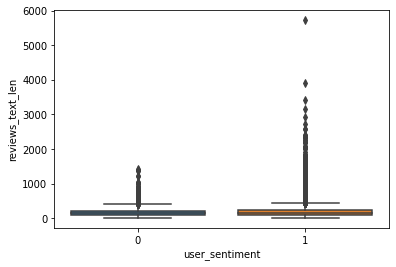

In [55]:
sns.boxplot(x="user_sentiment", y="reviews_text_len", data=ratings_df)

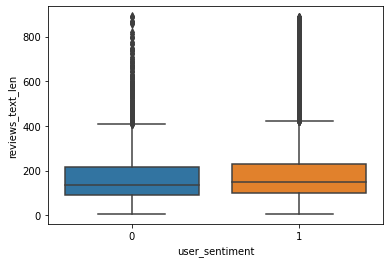

In [58]:
# Remove upper outliers and print box plot again.
outlier_high_cutoff = ratings_df['reviews_text_len'].quantile(0.99)
ratings_df_wo_outliers_df = ratings_df[ratings_df['reviews_text_len'] < outlier_high_cutoff]
sns.boxplot(x="user_sentiment", y="reviews_text_len", data=ratings_df_wo_outliers_df)

Size of the review isn't telling much about the sentiment

## **Prepare data for Modeling**

#### **Import & Helper functions**

In [59]:
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [60]:
# Create a lemmatizer
lemmatizer = WordNetLemmatizer()

In [63]:
def document_preprocess(document):
  # convert to lowercase 
  document = document.lower()

  # tokenize into words
  words = word_tokenize(document)

  # replace puntuations with space
  for i in range (0, len(words)):
    word = words[i]
    words[i] = "".join(char if char not in set(string.punctuation) else " " for char in word)

  # remove stop words
  words = [word for word in words if word not in stopwords.words("english")]

  # lemmatize 
  words = [lemmatizer.lemmatize(word) for word in words]

  document = " ".join(words)

  return document

In [64]:
print(document_preprocess("Best blu ray deal ever!.Al five of the first"))

best blu ray deal ever    al five first


In [65]:
print(document_preprocess("Really, No Words Can Describe The Awesomeness.Best coffee ice cream in the world, hands down!! Never tasted better."))

really   word describe awesomeness best coffee ice cream world   hand     never tasted better  


In [66]:
print(document_preprocess("Really, No Words Can Describe The Awesomeness.Best coffee ice cream in the world, hands down!! Never tasted better."))

really   word describe awesomeness best coffee ice cream world   hand     never tasted better  


In [67]:
def save_pickle_file(model, filename):
  pickle_filepath = f"{base_dir_path}/{filename}"
  pickle.dump(model, open(pickle_filepath, 'wb'))

def print_model_mertics(actual, predicted):
    display_confusion_matrix(actual, predicted)
    plt.show()
    metrics_df = generate_metrics_df(actual, predicted)
    return metrics_df

def display_confusion_matrix(actual, predicted):
    confusion = confusion_matrix(actual, predicted)
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in confusion.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in confusion.flatten()/np.sum(confusion)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(confusion, annot=labels, fmt="", cmap='Blues')

def generate_metrics_df(actual, predicted):
    confusion = confusion_matrix(actual, predicted)
    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives

    acc = metrics.accuracy_score(actual, predicted)
    recall = metrics.recall_score(actual, predicted)
    sensitivity = recall
    specificity = TP / float(TP+FN)
    precision = metrics.precision_score(actual, predicted)
    roc_auc_score = metrics.roc_auc_score(actual, predicted)
    f1 = metrics.f1_score(actual, predicted)
    df = pd.DataFrame(
        [[acc, sensitivity, specificity, recall, precision, roc_auc_score, f1]],
        columns = ["Accuracy", "Sensitivity", "Specificity", "Recall", "Precision", "ROC AUC", "F1"]
    )
    print(round(df,2))
    return df


# Defining the function to plot the ROC curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs, drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    return None

def find_optimal_cutoff(actual, prob):
    # Create Cutoff Data from for cutoffs from 0, 0.1, 0.2 .... 0.9
    cutoff_df = pd.DataFrame({
        'Churn': actual,
        'Churn_Prob': prob,
    })
    cutoff_options = np.arange(0.0, 1.0, 0.1)

    for i in cutoff_options:
        cutoff_df[i] = cutoff_df['Churn_Prob'].map(lambda x: 1 if x > i else 0)

    # Create Cutoff Metrics Datafram to save Accuracy, Sensitivity and Sepecificity for each cutoff point
    cutoff_metrics_df = pd.DataFrame(columns = ['Prob', 'Accuracy', 'Sensitivity', 'Specificity'])
    
    for prob in cutoff_options:
        actual = cutoff_df['Churn']
        predicted = cutoff_df[prob]

        confusion = confusion_matrix(actual, predicted)
        accuracy = metrics.accuracy_score(actual, predicted)
        sensitivity = metrics.recall_score(actual, predicted)
        specificity = confusion[0, 0] / (confusion[0, 0] + confusion[0, 1])

        cutoff_metrics_df.loc[prob] = [prob, accuracy, sensitivity, specificity]
    
    print(cutoff_metrics_df)
    
    # Plot Graph
    cutoff_metrics_df.plot.line(x='Prob', y=['Accuracy', 'Sensitivity', 'Specificity'])
    plt.vlines(x=0.5, ymax=1, ymin=0, colors="r", linestyles="--")
    plt.show()

#### **Create sentiment_df for sentiment analysis**

In [68]:
ratings_df.columns

Index(['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date',
       'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating',
       'reviews_userCity', 'reviews_userProvince', 'reviews_username',
       'user_sentiment', 'reviews_text', 'reviews_text_len'],
      dtype='object')

In [69]:
sentiment_df = ratings_df[['user_sentiment', 'reviews_text']]
sentiment_df.head()

,user_sentiment,reviews_text
3471,0,"Sunflower Swag. I was disappointed when I received this swag I ordered online and will definitely be returning it. First, the color of the sunflowers is more like a red/orange than yellow. Second, the petals on the sunflowers themselves were all bent. I thought they could easily be bent back in shape, but that isn't the case. I could iron them down, but I won't waste my time. For the price, it's not worth the purchase in my opinion. Sorry, this swag missed the mark for me."
26763,1,"Really, No Words Can Describe The Awesomeness. Best coffee ice cream in the world, hands down!! Never tasted better."
1228,1,Better Than Cheaper Finish. The cheaper Finish was leaving white residue on our dishes. This one is better and our dishes don't have as much white residue now.
16773,1,"Great. Great deal on four movies for the price of one, fast shipping and my mom loved them!"
18549,0,. My daughter adored the movie!


In [70]:
# Apply Preprocess function of every review.
# ETA: ~2.5 mins
%%time
sentiment_df['preprocessed_review'] = sentiment_df.reviews_text.apply(document_preprocess)
sentiment_df.head()

CPU times: user 1min 59s, sys: 11.2 s, total: 2min 10s
Wall time: 2min 10s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [71]:
preprocessed_reviews = sentiment_df['preprocessed_review']

# creating a bag-of-words model
all_words = []
for review in preprocessed_reviews:
  words = word_tokenize(review)
  for word in words:
    all_words.append(word)

all_words[:10]

['sunflower',
 'swag',
 'disappointed',
 'received',
 'swag',
 'ordered',
 'online',
 'definitely',
 'returning',
 'first']

In [72]:
print(f"Number of words in BOW is {len(all_words)}")

Number of words in BOW is 553300


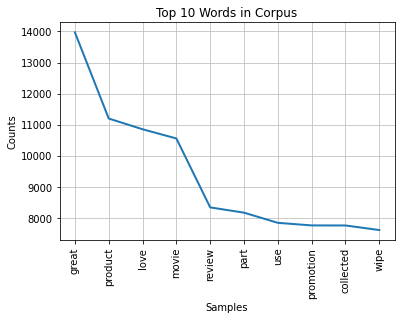

In [74]:
# Plot top 10 most common words in doc
words_freq_dist = nltk.FreqDist(all_words)
words_freq_dist.plot(10, title="Top 10 Words in Corpus")

#### **TF-IDF**

In [76]:
# Create tfidf dataframe
from sklearn.feature_extraction.text import TfidfVectorizer

# Let's try with 4000 features, we can modify this based on the results we see in the model
vectorizer = TfidfVectorizer(max_features=4000)
tfidf_model = vectorizer.fit_transform(sentiment_df['preprocessed_review'])
tfidf_df = pd.DataFrame(tfidf_model.toarray(), columns = vectorizer.get_feature_names())
tfidf_df.head(5)

,00,10,100,11,12,13,14,15,16,17,18,19,1950,1954,1998,1st,20,200,2000,2012,2013,2014,2016,21st,23,24,25,26,2d,2nd,2x,30,300,31,32,35,3d,3rd,40,45,...,wow,wrap,wrapped,wrinkle,write,writer,writing,written,wrong,wrote,www,wyler,xmas,ya,yay,yea,yeah,year,years,yellow,yes,yesterday,yet,yogurt,york,you,young,younger,youth,youthful,yr,yuck,yucky,yum,yummy,zac,zero,zilla,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.207817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
# Save Vectorizer pickle file
vectorizer_pickle_filename = "tfidf_vectorizer.pickle"
save_pickle_file(vectorizer, vectorizer_pickle_filename)

In [79]:
print(tfidf_df.shape)
print(tfidf_df.columns)

(27605, 4000)
Index(['00', '10', '100', '11', '12', '13', '14', '15', '16', '17',
       ...
       'yr', 'yuck', 'yucky', 'yum', 'yummy', 'zac', 'zero', 'zilla', 'zombie',
       'zone'],
      dtype='object', length=4000)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


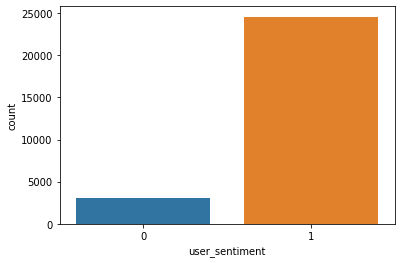

In [81]:
sns.countplot(sentiment_df.user_sentiment)

We can clearly see that the data is not balanced, so we will will look to fix this using SMOTE in the next section

#### **Handle Class  Imbalance using SMOTE**

Ref: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [84]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [85]:
# Setup X (features) and y (label)
X = tfidf_df.copy()
y = sentiment_df['user_sentiment']

In [86]:
%%time
over = SMOTE(random_state=100)
steps = [('o', over)]
pipeline = Pipeline(steps=steps)

# print original shape
print(f'Original Shape', X.shape, Counter(y))

# transform the dataset
X, y = pipeline.fit_resample(X, y)

# print shape after resampling
print(f'Shape after resampling', X.shape, Counter(y))

Original Shape (27605, 4000) Counter({1: 24552, 0: 3053})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Shape after resampling (49104, 4000) Counter({0: 24552, 1: 24552})
CPU times: user 1min 10s, sys: 647 ms, total: 1min 10s
Wall time: 1min 10s


Now the class is equally distributed

Counter({0: 24552, 1: 24552})


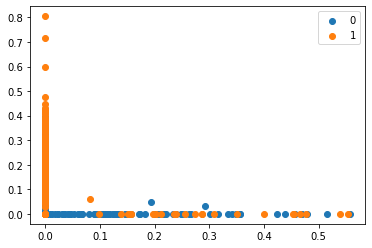

In [87]:
# Visualize the distribution
from numpy import where
# summarize the new class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y == label)[0]
	plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

## **Divide the data into train and test**

In [88]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100, stratify=y)
print("Make sure the percentage distribution of churn in train and test is similar")
print(f"Positive sentiment percentage in train data = {round(100 * y_train.sum()/len(y_train), 2)}%")
print(f"Positive sentiment percentage in test data = {round(100 * y_test.sum()/len(y_test), 2)}%")

Make sure the percentage distribution of churn in train and test is similar
Positive sentiment percentage in train data = 50.0%
Positive sentiment percentage in test data = 50.0%


In [89]:
print(X_train.shape)
print(X_test.shape)

(34372, 4000)
(14732, 4000)


## **LOGISTIC REGRESSION**

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [92]:
%%time
lr_model = LogisticRegression(class_weight='balanced', random_state=100).fit(X_train, y_train)

CPU times: user 38.9 s, sys: 1.95 s, total: 40.9 s
Wall time: 10.4 s


In [93]:
# Predict Proba
y_train_proba = lr_model.predict_proba(X_train)[:, 1]
y_test_proba = lr_model.predict_proba(X_test)[:, 1]

# create pred df for train and test
train_pred_prob_df = pd.DataFrame ({
    'Sentiment': y_train.tolist(),
    'Sentiment Pred Prob': y_train_proba,
})
test_pred_prob_df = pd.DataFrame ({
    'Sentiment': y_test.tolist(),
    'Sentiment Pred Prob': y_test_proba,
})

In [94]:
train_pred_prob_df.head(5)

,Sentiment,Sentiment Pred Prob
0,1,0.742953
1,1,0.990332
2,0,0.021680
3,1,0.729164
4,0,0.200412


In [95]:
test_pred_prob_df.head(5)

,Sentiment,Sentiment Pred Prob
0,0,0.289810
1,1,0.772360
2,0,0.002576
3,1,0.553832
4,1,0.871587


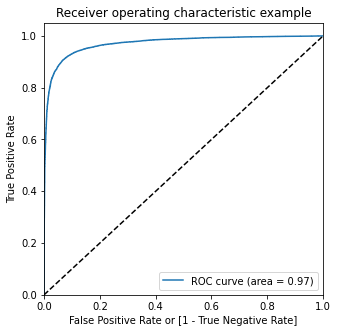

In [96]:
# Draw ROC Curve
train_pred_prob_df = pd.DataFrame ({
    'Sentiment': y_train.tolist(),
    'Sentiment Pred Prob': y_train_proba,
})
draw_roc(train_pred_prob_df['Sentiment'], train_pred_prob_df['Sentiment Pred Prob'])

ROC Curve has a nice bend towards the top left which is good.

     Prob  Accuracy  Sensitivity  Specificity
0.0  0.0   0.500000  1.000000     0.000000   
0.1  0.1   0.662778  0.994589     0.330967   
0.2  0.2   0.804608  0.983300     0.625916   
0.3  0.3   0.883713  0.962237     0.805190   
0.4  0.4   0.916153  0.929187     0.903119   
0.5  0.5   0.916735  0.885546     0.947923   
0.6  0.6   0.902159  0.830967     0.973350   
0.7  0.7   0.869720  0.753578     0.985861   
0.8  0.8   0.819068  0.645584     0.992552   
0.9  0.9   0.741126  0.484697     0.997556   


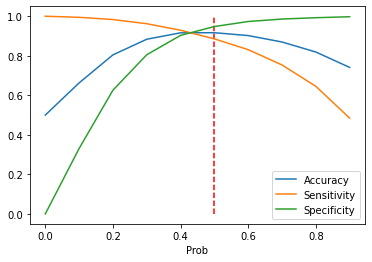

In [97]:
# Find Optimal Cutoff 
find_optimal_cutoff(train_pred_prob_df['Sentiment'], train_pred_prob_df['Sentiment Pred Prob'])

In [98]:
lr_optimal_cutoff_point = 0.42

In [99]:
train_pred_prob_df.head()

,Sentiment,Sentiment Pred Prob
0,1,0.742953
1,1,0.990332
2,0,0.021680
3,1,0.729164
4,0,0.200412


In [100]:
# create Prediction on train data
train_pred_prob_df['Prediction'] = train_pred_prob_df['Sentiment Pred Prob'].map(lambda x: 1 if x >= lr_optimal_cutoff_point else 0) 
train_pred_prob_df.head()

,Sentiment,Sentiment Pred Prob,Prediction
0,1,0.742953,1
1,1,0.990332,1
2,0,0.021680,0
3,1,0.729164,1
4,0,0.200412,0


In [101]:
# create Prediction on test data
test_pred_prob_df['Prediction'] = test_pred_prob_df['Sentiment Pred Prob'].map(lambda x: 1 if x >= lr_optimal_cutoff_point else 0) 
test_pred_prob_df.head()

,Sentiment,Sentiment Pred Prob,Prediction
0,0,0.289810,0
1,1,0.772360,1
2,0,0.002576,0
3,1,0.553832,1
4,1,0.871587,1


In [102]:
# view metrics on train predictions
lr_train_metrics = generate_metrics_df(train_pred_prob_df['Sentiment'], train_pred_prob_df['Prediction'])

   Accuracy  Sensitivity  Specificity  Recall  Precision  ROC AUC    F1
0  0.92      0.92         0.92         0.92    0.92       0.92     0.92


In [103]:
# view metrics on test predictions
lr_test_metrics = generate_metrics_df(test_pred_prob_df['Sentiment'], test_pred_prob_df['Prediction'])

   Accuracy  Sensitivity  Specificity  Recall  Precision  ROC AUC   F1
0  0.9       0.9          0.9          0.9     0.9        0.9      0.9


**Observation**

- Not only are we getting good result on accuracy, but the F1 score is good as well.
- In addition to accuracy, we want to care about F1 score as well because we want False Positive and False Negatives to be in check.

In [104]:
# Save LR pickle file 
lr_pickle_filename = "lr_sentiment_analysis_model.pickle"
save_pickle_file(lr_model, lr_pickle_filename)

## **Random Forest**

In [105]:
from sklearn.ensemble import RandomForestClassifier

In [106]:
%%time
# Create the parameter grid based on the results of random search 
param_distributions = {
    'max_depth': [40, 80],
    'min_samples_split': [20, 40],
    'n_estimators': [100, 200]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
rf_random_search = RandomizedSearchCV(
  estimator = rf,
  param_distributions = param_distributions,
  cv = 3,
  n_jobs = -1,
  # verbose = 1
)

# Fit the grid search to the data
rf_random_search.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


CPU times: user 1min 46s, sys: 1.12 s, total: 1min 47s
Wall time: 12min 30s


In [107]:
print('Best Score', rf_random_search.best_score_)
print('Best Params ', rf_random_search.best_params_)

Best Score 0.9289538096409107
Best Params  {'n_estimators': 100, 'min_samples_split': 20, 'max_depth': 80}


In [108]:
# train prediction
rf_train_predictions = rf_random_search.predict(X_train)
rf_train_metrics = generate_metrics_df(y_train, rf_train_predictions)

   Accuracy  Sensitivity  Specificity  Recall  Precision  ROC AUC    F1
0  0.99      0.98         0.98         0.98    1.0        0.99     0.99


In [109]:
rf_predictions_proba = rf_random_search.predict_proba(X_train)[:, 1]
rf_predictions_proba

array([0.83033396, 0.89664176, 0.08188451, ..., 0.87236646, 0.16600606,
       0.94060407])

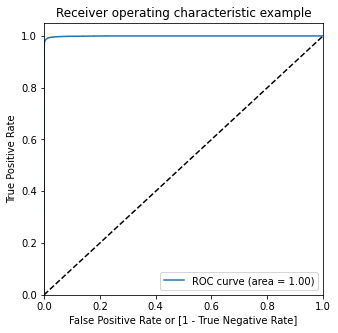

In [110]:
# draw_roc(train_pred_prob_df['Sentiment'], train_pred_prob_df['Sentiment Pred Prob'])
draw_roc(y_train, rf_predictions_proba)

     Prob  Accuracy  Sensitivity  Specificity
0.0  0.0   0.500000  1.000000     0.000000   
0.1  0.1   0.638572  1.000000     0.277144   
0.2  0.2   0.856220  1.000000     0.712440   
0.3  0.3   0.953858  0.998604     0.909112   
0.4  0.4   0.985308  0.994589     0.976027   
0.5  0.5   0.989875  0.984639     0.995112   
0.6  0.6   0.979285  0.959269     0.999302   
0.7  0.7   0.935325  0.870709     0.999942   
0.8  0.8   0.832945  0.665891     1.000000   
0.9  0.9   0.641307  0.282614     1.000000   


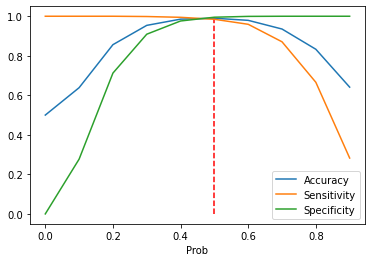

In [111]:
# find_optimal_cutoff(train_pred_prob_df['Sentiment'], train_pred_prob_df['Sentiment Pred Prob'])
find_optimal_cutoff(y_train, rf_predictions_proba)

In [112]:
rf_optimal_cutoff_point = 0.45

In [113]:
y_pred_w_cutoff = list(map(lambda x: 1 if x >= rf_optimal_cutoff_point else 0, rf_predictions_proba))
generate_metrics_df(y_train, y_pred_w_cutoff)

   Accuracy  Sensitivity  Specificity  Recall  Precision  ROC AUC    F1
0  0.99      0.99         0.99         0.99    0.99       0.99     0.99


,Accuracy,Sensitivity,Specificity,Recall,Precision,ROC AUC,F1
0,0.989468,0.990341,0.990341,0.990341,0.988615,0.989468,0.989477


In [114]:
# test predict
rf_test_predictions = rf_random_search.predict(X_test)
# Generate matrics
rf_test_metrics = generate_metrics_df(y_test, rf_test_predictions)

   Accuracy  Sensitivity  Specificity  Recall  Precision  ROC AUC    F1
0  0.94      0.92         0.92         0.92    0.96       0.94     0.94


**Observation**

- Getting really good score for Accuracy and F1. 
- Looking better than Logistic Regression Model.

In [115]:
# Save RF pickle file 
rf_pickle_filename = "rf_sentiment_analysis_model.pickle"
save_pickle_file(rf_random_search, rf_pickle_filename)

## **XG Boost**

In [116]:
import xgboost as xgb

In [118]:
# %%time
# # param_distributions = {
# #     'n_estimators': [200, 400],
# #     'max_depth': [80, 100],
# #     'learning_rate': [0.05, 0.2]
# # }
# param_distributions = {
#   'n_estimators': [100, 200],
#   'max_depth': [2, 5],
#   'learning_rate': [0.05, 0.2]
# }

# # Create a based model
# # xgboost_model = xgb.XGBClassifier(objective="binary:logistic")
# xgboost_model = xgb.XGBClassifier()

# # Instantiate the random search model
# xgb_random_search = RandomizedSearchCV(
#   estimator = xgboost_model,
#   param_distributions = param_distributions,
#   cv = 3,
#   n_jobs = -1,
#   verbose = 1
# )

# # Fit the random search to the data
# xgb_random_search.fit(X_train, y_train)

# print('Best Score', random_search.best_score_)
# print('Best Params ', random_search.best_params_)

In [119]:
xgboost_model = xgb.XGBClassifier(
    n_estimators = 200,
    seed=2,
    colsample_bytree=0.6,
    subsample=0.7,
    random_state=42,
)

xgboost_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=2,
              silent=None, subsample=0.7, verbosity=1)

In [120]:
# train prediction
xgb_train_predictions = xgboost_model.predict(X_train)
xgb_train_metrics = generate_metrics_df(y_train, xgb_train_predictions)

   Accuracy  Sensitivity  Specificity  Recall  Precision  ROC AUC    F1
0  0.87      0.84         0.84         0.84    0.89       0.87     0.87


In [121]:
# test predict
xgb_test_predictions = xgboost_model.predict(X_test)
# Generate matrics
xgb_test_metrics = generate_metrics_df(y_test, xgb_test_predictions)

   Accuracy  Sensitivity  Specificity  Recall  Precision  ROC AUC    F1
0  0.86      0.83         0.83         0.83    0.88       0.86     0.85


In [122]:
# Save RF pickle file 
xgb_pickle_filename = "xgb_sentiment_analysis_model.pickle"
save_pickle_file(xgboost_model, xgb_pickle_filename)

## **Select Best Model**

In [123]:
print(lr_test_metrics)
print(rf_test_metrics)
print(xgb_test_metrics)
# sentiment_analysis_model = lr_model

   Accuracy  Sensitivity  Specificity    Recall  Precision   ROC AUC        F1
0  0.900149  0.902661     0.902661     0.902661  0.898149   0.900149  0.900399
   Accuracy  Sensitivity  Specificity    Recall  Precision   ROC AUC        F1
0  0.940605  0.919088     0.919088     0.919088  0.96042    0.940605  0.939299
   Accuracy  Sensitivity  Specificity    Recall  Precision   ROC AUC        F1
0  0.857114  0.827315     0.827315     0.827315  0.879746   0.857114  0.852725


Random Forest is clearly the winner here

In [125]:
# Save RF pickle file as final sentiment analysis model
final_pickle_filename = "final_sentiment_analysis_model.pickle"
save_pickle_file(rf_random_search, final_pickle_filename)

In [131]:
sentiment_analysis_model = rf_random_search

## **Create Product Sentiment Score DF**

- As one of the options, We will use this df to precalculate and save the sentiment score of each product.
- Then, we will use this score for sorting in descending order to find the best product to recommend.

In [126]:
# Create ratings dataframe from csv
og_ratings_df = pd.read_csv(f"{base_dir_path}/sample30.csv")
og_ratings_df.shape

(30000, 15)

In [127]:
print(ratings_df.shape)
print(ratings_df.columns)
print('----')
print(sentiment_df.shape)
print(sentiment_df.columns)

(27605, 15)
Index(['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date',
       'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating',
       'reviews_userCity', 'reviews_userProvince', 'reviews_username',
       'user_sentiment', 'reviews_text', 'reviews_text_len'],
      dtype='object')
----
(27605, 3)
Index(['user_sentiment', 'reviews_text', 'preprocessed_review'], dtype='object')


In [128]:
# copy preprocessed reviews from sentiment df to ratings df
ratings_df['preprocessed_review'] = sentiment_df['preprocessed_review']

In [129]:
# Create product sentiment score df
product_sentiment_score_df = ratings_df[['name', 'preprocessed_review', 'reviews_text']]
product_sentiment_score_df.head(3)

,name,preprocessed_review,reviews_text
3471,Sunflower Swag With Metal Frame - Nearly Natural,sunflower swag disappointed received swag ordered online definitely returning first color sunflower like red orange yellow second petal sunflower bent thought could easily bent back shape n t case could iron wo n t waste time price s worth purchase opinion sorry swag missed mark,"Sunflower Swag. I was disappointed when I received this swag I ordered online and will definitely be returning it. First, the color of the sunflowers is more like a red/orange than yellow. Second, the petals on the sunflowers themselves were all bent. I thought they could easily be bent back in shape, but that isn't the case. I could iron them down, but I won't waste my time. For the price, it's not worth the purchase in my opinion. Sorry, this swag missed the mark for me."
26763,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint",really word describe awesomeness best coffee ice cream world hand never tasted better,"Really, No Words Can Describe The Awesomeness. Best coffee ice cream in the world, hands down!! Never tasted better."
1228,"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",better cheaper finish cheaper finish leaving white residue dish one better dish n t much white residue,Better Than Cheaper Finish. The cheaper Finish was leaving white residue on our dishes. This one is better and our dishes don't have as much white residue now.


In [132]:
# Try out transformation and prediction using product_sentiment_score_df
print("Vector Transforming")
tfidf_model = vectorizer.transform(product_sentiment_score_df['preprocessed_review'])
tfidf_df = pd.DataFrame(tfidf_model.toarray(), columns = vectorizer.get_feature_names())

cutoff = 0.45
print("Making Prediction")
product_sentiment_score_df["pos_sentiment_prob"] = sentiment_analysis_model.predict_proba(tfidf_df)[:, 1]
product_sentiment_score_df["sentiment_pred"] = product_sentiment_score_df['pos_sentiment_prob'].map(lambda x: 1 if x >= cutoff else 0)

Vector Transforming
Making Prediction


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [133]:
product_sentiment_score_df.groupby('name')['sentiment_pred'].mean().sort_values(ascending=False)

name
Plum Organics Just Prunes                                                                 1.0
Lundberg Organic Cinnamon Toast Rice Cakes                                                1.0
Germ Guardian174 Elite 3-In-1 Pet Pure True Hepa Air Purifier Ac4300bptca                 1.0
Reebok Classic Leather Running Shoes - White (Men)                                        1.0
Romantic Drama: Greatest Classic Films Collection 2 Discs                                 1.0
                                                                                         ... 
Nearly Natural Pothos Ledge Plant (set On Foam) Silk Plant                                0.0
Pearhead Id Bracelet Frame                                                                0.0
Smead174 Recycled Letter Size Manila File Backs W/prong Fasteners, 2 Capacity, 100/box    0.0
Pocket Watch Wall Clock Distressed Black - Yosemite Home Decor174                         0.0
Lite Source Reiko 1 Light Table Lamp - Orange          

In [134]:
prod_list = product_sentiment_score_df.groupby('name')['sentiment_pred'].mean().index.tolist()
sent_score_list = product_sentiment_score_df.groupby('name')['sentiment_pred'].mean().values.tolist()
prod_sent_score = pd.DataFrame(data = {
    "product": prod_list,
    "sentiment_score": sent_score_list
})

prod_sent_score.head(20)

,product,sentiment_score
0,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,0.500000
1,100:Complete First Season (blu-Ray),0.933333
2,2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.250000
3,"2x Ultra Era with Oxi Booster, 50fl oz",0.800000
4,"42 Dual Drop Leaf Table with 2 Madrid Chairs""",1.000000
5,4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.666667
6,5302050 15/16 FCT/HOSE ADAPTOR,0.000000
7,Africa's Best No-Lye Dual Conditioning Relaxer System Super,0.833333
8,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,0.666667
9,Alex Cross (dvdvideo),0.800000


In [135]:
prod_sent_score[prod_sent_score['product'].isin(prod_list[:5])].sort_values(by="sentiment_score", ascending=False)

,product,sentiment_score
4,"42 Dual Drop Leaf Table with 2 Madrid Chairs""",1.000000
1,100:Complete First Season (blu-Ray),0.933333
3,"2x Ultra Era with Oxi Booster, 50fl oz",0.800000
0,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,0.500000
2,2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.250000


In [136]:
# Save as pickle file
prod_sent_score_filename = "product_sentiment_score_df.pickle"
save_pickle_file(prod_sent_score, prod_sent_score_filename)

In [137]:
top_products_df = prod_sent_score[prod_sent_score['product'].isin(prod_list[:5])].sort_values(by="sentiment_score", ascending=False)
top_products_df.head()

,product,sentiment_score
4,"42 Dual Drop Leaf Table with 2 Madrid Chairs""",1.000000
1,100:Complete First Season (blu-Ray),0.933333
3,"2x Ultra Era with Oxi Booster, 50fl oz",0.800000
0,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,0.500000
2,2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.250000


In [138]:
# Convert prodcuts to list
top_products_df['product'].tolist()

['42 Dual Drop Leaf Table with 2 Madrid Chairs"',
 '100:Complete First Season (blu-Ray)',
 '2x Ultra Era with Oxi Booster, 50fl oz',
 '0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest',
 '2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black']

Looks Good

In this notebook, we created pickle files for :-
1. Vectorizer
2. All 3 Models (Logistic Regression, Random Forest and XGBoost). We found that Random Forest is the best model by checking model accuracy and F1 score.
3. Product sentiment Score. Looping and running predictions can be slow. This can be used for lookup if we can use prerecorded sentiment score for a product.


With that, we come to the end of this notebook.

## **END**